In [1]:
# 获取Google网盘的访问权限

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset

In [0]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [0]:
# Hyper-parameters
sequence_length = 128
input_size = 128*3
hidden_size = 128*3*4
num_layers = 2
num_classes = 19
# batch_size = 100
batch_size = 10
num_epochs = 20 #32
#learning_rate = 0.01
learning_rate = 0.00005


In [0]:
# 加载训练集与测试集

train_txt_path = './gdrive/My Drive/remote/RSDataset/train.txt'
test_txt_path = './gdrive/My Drive/remote/RSDataset/test.txt'

class MyDataset(Dataset):
    def __init__(self, txt_path, transform = None, target_transform = None):
        fh = open(txt_path, 'r')
        imgs = []
        for line in fh:
            line = line.rstrip()
            words = line.split()
            imgs.append((words[0]+' '+words[1],int(words[2])))

        self.imgs = imgs        # 最主要就是要生成这个list， 然后DataLoader中给index，通过getitem读取图片数据
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        fn, label = self.imgs[index]
        img = Image.open(fn).convert('RGB')     # 像素值 0~255，在transfrom.totensor会除以255，使像素值变成 0~1

        if self.transform is not None:
            img = self.transform(img)   # 在这里做transform，转为tensor等等

        return img, label

    def __len__(self):
        return len(self.imgs)
      
train_data = MyDataset(txt_path=train_txt_path, transform = transform)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_data = MyDataset(txt_path=test_txt_path, transform = transform)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

In [0]:
# Recurrent neural network (many-to-one)
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.5):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.5) #dropout=0.5
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [0]:
# Loss criterion
criterion = nn.CrossEntropyLoss()

In [0]:
# Train the model

def train(model, train_loader, num_epochs, sequence_length, input_size, device, learning_rate):

    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    Loss_list = []
    j = 0;


    total_step = len(train_loader)
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            images = images.reshape(-1, sequence_length, input_size).to(device)
            #labels = class_label.index(labels)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % 10 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
                Loss_list.append(loss.item())
                j = j+1
    x = range(j)
    plt.plot(x, Loss_list, '.-')

In [0]:
# Test the model

def test(model, test_loader, sequence_length, input_size, device):

    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.reshape(-1, sequence_length, input_size).to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Test Accuracy of the model on test images: {} %'.format(100 * correct / total)) 
        print('Loss: ',loss.item())
        return (100 * correct / total)

Epoch [1/20], Step [10/80], Loss: 3.6048
Epoch [1/20], Step [20/80], Loss: 3.9196
Epoch [1/20], Step [30/80], Loss: 3.7927
Epoch [1/20], Step [40/80], Loss: 3.0884
Epoch [1/20], Step [50/80], Loss: 2.9193
Epoch [1/20], Step [60/80], Loss: 3.6279
Epoch [1/20], Step [70/80], Loss: 2.6110
Epoch [1/20], Step [80/80], Loss: 3.5176
Epoch [2/20], Step [10/80], Loss: 2.5876
Epoch [2/20], Step [20/80], Loss: 2.4729
Epoch [2/20], Step [30/80], Loss: 2.5947
Epoch [2/20], Step [40/80], Loss: 2.6394
Epoch [2/20], Step [50/80], Loss: 3.1425
Epoch [2/20], Step [60/80], Loss: 2.4493
Epoch [2/20], Step [70/80], Loss: 3.1356
Epoch [2/20], Step [80/80], Loss: 1.7789
Epoch [3/20], Step [10/80], Loss: 3.2014
Epoch [3/20], Step [20/80], Loss: 2.3266
Epoch [3/20], Step [30/80], Loss: 2.2604
Epoch [3/20], Step [40/80], Loss: 3.2113
Epoch [3/20], Step [50/80], Loss: 3.4956
Epoch [3/20], Step [60/80], Loss: 3.9127
Epoch [3/20], Step [70/80], Loss: 2.2823
Epoch [3/20], Step [80/80], Loss: 3.1362
Epoch [4/20], St

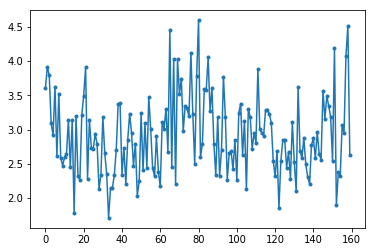

In [30]:
# 对LSTM进行训练和测试

model = RNN(input_size, hidden_size, num_layers, num_classes, dropout=0.5).to(device)
train(model, train_loader, num_epochs, sequence_length, input_size, device, learning_rate)# learning_rate
test(model, test_loader, sequence_length, input_size, device)

Epoch [1/20], Step [10/80], Loss: 2.9431
Epoch [1/20], Step [20/80], Loss: 2.9491
Epoch [1/20], Step [30/80], Loss: 2.9249
Epoch [1/20], Step [40/80], Loss: 2.9250
Epoch [1/20], Step [50/80], Loss: 2.8980
Epoch [1/20], Step [60/80], Loss: 2.9247
Epoch [1/20], Step [70/80], Loss: 2.8597
Epoch [1/20], Step [80/80], Loss: 2.9393
Epoch [2/20], Step [10/80], Loss: 2.9298
Epoch [2/20], Step [20/80], Loss: 2.8458
Epoch [2/20], Step [30/80], Loss: 2.9006
Epoch [2/20], Step [40/80], Loss: 2.9242
Epoch [2/20], Step [50/80], Loss: 2.8955
Epoch [2/20], Step [60/80], Loss: 2.7328
Epoch [2/20], Step [70/80], Loss: 2.8272
Epoch [2/20], Step [80/80], Loss: 2.8476
Epoch [3/20], Step [10/80], Loss: 2.6695
Epoch [3/20], Step [20/80], Loss: 2.6955
Epoch [3/20], Step [30/80], Loss: 2.6191
Epoch [3/20], Step [40/80], Loss: 2.6629
Epoch [3/20], Step [50/80], Loss: 2.6550
Epoch [3/20], Step [60/80], Loss: 2.9217
Epoch [3/20], Step [70/80], Loss: 2.5030
Epoch [3/20], Step [80/80], Loss: 2.8673
Epoch [4/20], St

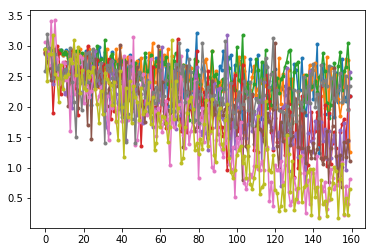

In [28]:
# 观察learning rate和dropout的取值对LSTM模型的训练效果的影响

dropout = [0.3, 0.5, 0.7]
learning_rate = [0.000005,0.00005,0.0005]
accuracy = { }
for i,lr in enumerate(learning_rate):
  for j, dp in enumerate(dropout):
    model = RNN(input_size, hidden_size, num_layers, num_classes, dropout=dp).to(device)
    train(model, train_loader, num_epochs, sequence_length, input_size, device, lr)
    test_accuracy = test(model, test_loader, sequence_length, input_size, device)
    accuracy[(lr, dp)] = test_accuracy

In [0]:
for lr, dp in sorted(accuracy):
  test_accuracy = accuracy[(lr, dp)]
  print('lr %e dp %e test accuracy: %f' % (lr, dp, test_accuracy))